# Gaussian Process

## Latent Variable Implementation

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import theano
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context('notebook')
np.random.seed(12345)
rc = {'xtick.labelsize': 10, 'ytick.labelsize': 10, 'axes.labelsize': 10, 'font.size': 10, 
      'legend.fontsize': 12.0, 'axes.titlesize': 10, "figure.figsize": [14, 6]}
sns.set(rc = rc)
sns.set_style("whitegrid")

### Step 1: Prepare the data

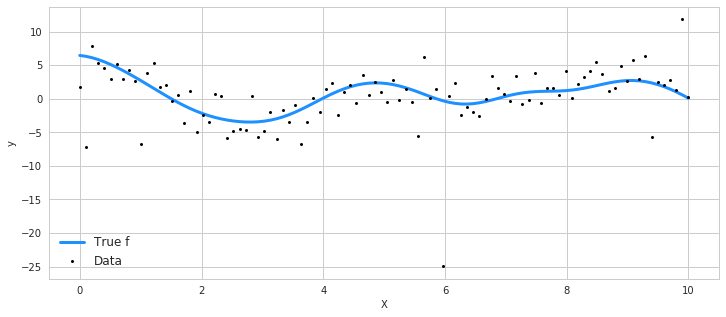

In [2]:
n = 100 # The number of data points
X = np.linspace(0, 10, n)[:, None] # The inputs to the GP, they must be arranged as a column vector

# Define the true covariance function and its parameters
length_scale_true = 1.0
signal_variance_true = 3.0
cov_func = signal_variance_true**2 * pm.gp.cov.ExpQuad(1, length_scale_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true = np.random.multivariate_normal(mean_func(X).eval(),
                                       cov_func(X).eval() + 1e-8*np.eye(n), 1).flatten()

# The observed data is the latent function plus a small amount of T distributed noise
# The standard deviation of the noise is `sigma`, and the degrees of freedom is `nu`
noise_variance_true = 2.0
degrees_of_freedom_true = 3.0
y = f_true + noise_variance_true * np.random.standard_t(degrees_of_freedom_true, size=n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12,5))
ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True f");
ax.plot(X, y, 'ok', ms=3, label="Data");
ax.set_xlabel("X"); ax.set_ylabel("y"); plt.legend();

### Step 2: Build the model

In [3]:
with pm.Model() as latent_gp_model:
    
    # specify the priors
    length_scale = pm.Gamma("length_scale", alpha = 2, beta = 1)
    signal_variance = pm.HalfCauchy("signal_variance", beta = 5)
    noise_variance = pm.HalfCauchy("noise_variance", beta = 5)
    degrees_of_freedom = pm.Gamma("degrees_of_freedom", alpha = 2, beta = 0.1)
    
    # specify the kernel function
    cov = signal_variance**2 * pm.gp.cov.ExpQuad(1, length_scale)
        
    # specify the mean function
    mean_function = pm.gp.mean.Zero()
    
    # specify the gp
    gp = pm.gp.Latent(cov_func = cov)
    
    # specify the prior over the latent function
    f = gp.prior("f", X = X) 
    
    # specify the likelihood
    obs = pm.StudentT("obs", mu = f, lam = 1/signal_variance, nu = degrees_of_freedom, observed = y)

### Step 3: Sample from the posterior

In [4]:
with latent_gp_model:
    posterior = pm.sample(draws = 100, njobs = 2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
 96%|█████████▌| 573/600 [01:22<00:03,  6.92it/s]/home/ubuntu/anaconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:429: UserWarning: Chain 1 contains only 100 samples.
  % (self._chain_id, n))
100%|██████████| 600/600 [01:24<00:00,  7.11it/s]/home/ubuntu/anaconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:429: UserWarning: Chain 0 contains only 100 samples.
  % (self._chain_id, n))



### Step 4: Diagnose the convergence of MCMC chains

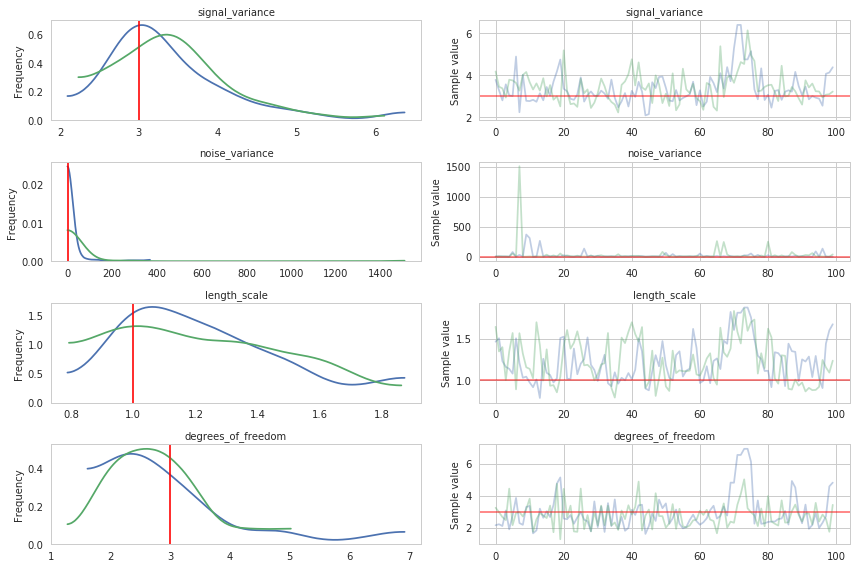

In [5]:
pm.traceplot(posterior, lines = {"signal_variance": signal_variance_true, 
                                 "noise_variance": noise_variance_true, 
                                 "length_scale": length_scale_true, 
                                 "degrees_of_freedom": degrees_of_freedom_true}, 
             varnames=["signal_variance", "noise_variance", "length_scale", "degrees_of_freedom"]);

In [6]:
pm.gelman_rubin(posterior, varnames=["signal_variance", "noise_variance", "length_scale", "degrees_of_freedom"])

{'degrees_of_freedom': 1.0069394817642983,
 'length_scale': 0.99509870686658441,
 'noise_variance': 0.99773048504811679,
 'signal_variance': 0.99627208585581017}

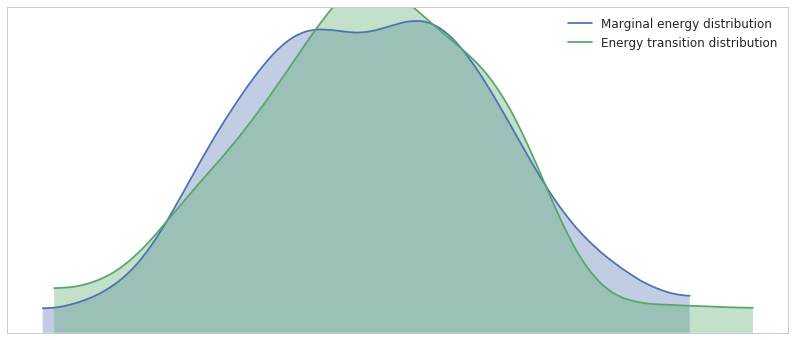

In [7]:
pm.energyplot(posterior)

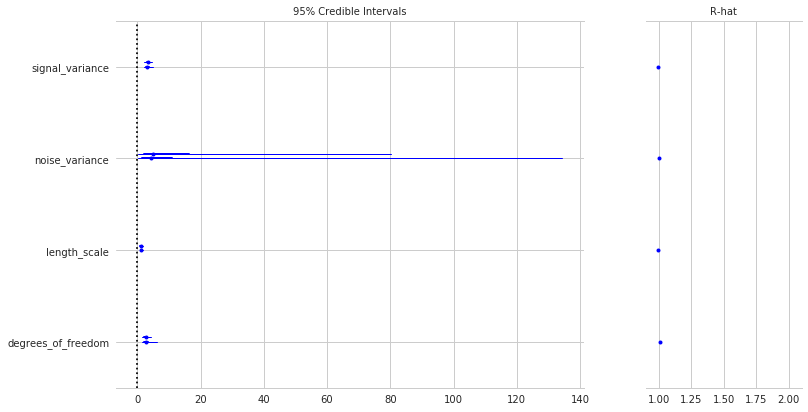

In [8]:
pm.forestplot(posterior, varnames=["signal_variance", "noise_variance", "length_scale", "degrees_of_freedom"])

In [9]:
# if convergence is okay, same the model as a pickel object
# save it to the file 'latent_gp.pkl' for later use
import pickle
with open('latent_gp.pkl', 'wb') as f:
    pickle.dump(posterior, f, protocol=pickle.HIGHEST_PROTOCOL)

### Step 5: Criticize the model

In [10]:
# load it at some future point
#with open('latent_gp.pkl', 'rb') as f:
#    posterior = pickle.load(f)

In [11]:
pm.summary(posterior, varnames=["signal_variance", "noise_variance", "length_scale", "degrees_of_freedom"])


signal_variance:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  3.394            0.736            0.062            [2.092, 4.750]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  2.333          2.899          3.262          3.709          5.268


noise_variance:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  27.169           116.534          8.041            [0.089, 88.042]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.175          1.685          4.625          13.849         259.247


length_scale:

  Mean             SD               MC Error         95% HPD interva

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0d41414710>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f0d345282b0>], dtype=object)

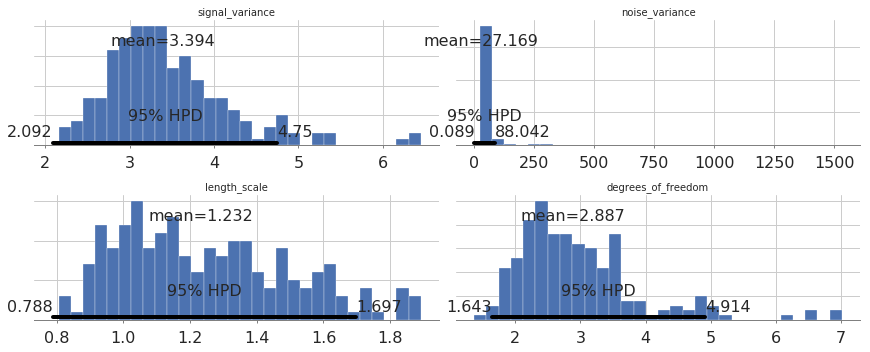

In [12]:
pm.plot_posterior(posterior, varnames=["signal_variance", "noise_variance", "length_scale", "degrees_of_freedom"])

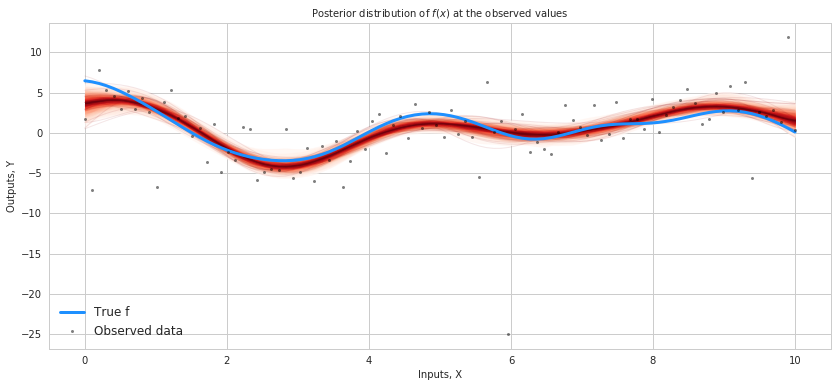

In [13]:
# plot the results
fig = plt.figure(figsize = (14, 6))
ax = fig.gca()

# plot the samples of the gp posterior
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, posterior["f"], X)

# plot the data and the true function
plt.plot(X, f_true, "dodgerblue", lw = 3, label = "True f")
plt.plot(X, y, "ok", ms = 3, alpha = 0.5, label = "Observed data")

# axis labels and title
plt.xlabel("Inputs, X"); plt.ylabel("Outputs, Y")
plt.title("Posterior distribution of $f(x)$ at the observed values")
plt.legend()

### Step 6: Use the model for prediction

In [14]:
# prepare test dataset
# 200 new values from x=0 to x=15
n_new = 200
X_new = np.linspace(0, 15, n_new)[:,None]

In [15]:
# extend the model by adding the GP conditional distribution so as to predict at test data
with latent_gp_model:
    f_pred = gp.conditional("f_pred", X_new)

In [16]:
# sample from the GP conditional posterior
with latent_gp_model:
    posterior_pred = pm.sample_ppc(posterior, vars = [f_pred], samples = 200)

100%|██████████| 200/200 [00:05<00:00, 35.72it/s]


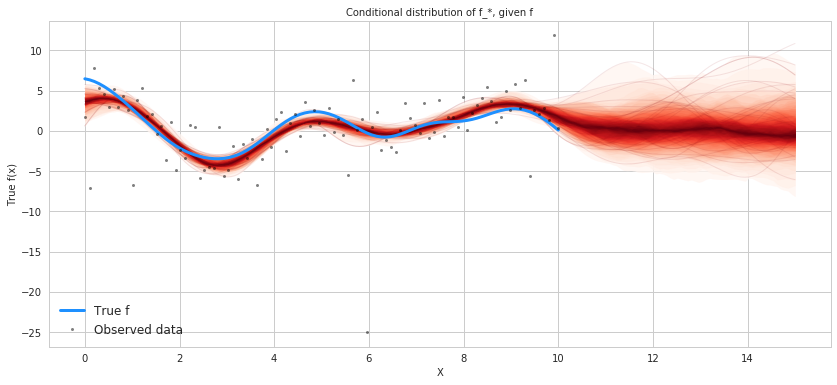

In [18]:
# plot the results
fig = plt.figure(figsize=(14,6)); ax = fig.gca()
plot_gp_dist(ax, posterior_pred["f_pred"], X_new);
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");
plt.xlabel("X"); plt.ylabel("True f(x)");
plt.title("Conditional distribution of f_*, given f"); plt.legend();